In [ ]:
# Install required libraries
!pip install torch torchvision pandas numpy pillow scikit-learn matplotlib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Imports
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as T
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.ops import misc as misc_nn_ops
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Set the path to your dataset
base_path = "/content/drive/MyDrive/final_dataset"
train_path = f"{base_path}/train/"
valid_path = f"{base_path}/valid/"

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

class LunarDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = ['Crater', 'Boulder']  # Only foreground classes
        self.class_to_idx = {cls: idx + 1 for idx, cls in enumerate(self.classes)}  # Map to 1, 2 (0 is background)

    def __len__(self):
        return len(self.annotations['filename'].unique())

    def __getitem__(self, idx):
        img_name = self.annotations['filename'].unique()[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Filter out 'Plain surface' annotations
        img_annotations = self.annotations[self.annotations['filename'] == img_name]
        boxes = []
        labels = []
        for _, row in img_annotations.iterrows():
            class_name = row['class']
            if class_name in self.class_to_idx:  # Only include Crater and Boulder
                xmin, ymin, xmax, ymax = row[['xmin', 'ymin', 'xmax', 'ymax']]
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.class_to_idx[class_name])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Handle empty annotations (no foreground objects)
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 else torch.tensor([]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transform:
            image = self.transform(image)

        return image, target, img_name

In [ ]:
# Define transforms with normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = LunarDataset(csv_file=f"{train_path}/_annotations.csv", img_dir=train_path, transform=transform)
valid_dataset = LunarDataset(csv_file=f"{valid_path}/_annotations.csv", img_dir=valid_path, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import torchvision.ops.misc as misc_nn_ops

# Define EfficientNet-B3 Backbone
def get_efficientnet_backbone():
    backbone = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
    features = backbone.features

    return_layers = {
        'layer_2': '0',  # 32 channels
        'layer_4': '1',  # 96 channels
        'layer_6': '2',  # 232 channels
        'layer_8': '3'   # 1536 channels
    }

    class EfficientNetBackbone(torch.nn.Module):
        def __init__(self, features):
            super().__init__()
            self.layer_2 = torch.nn.Sequential(*features[:3])
            self.layer_4 = torch.nn.Sequential(*features[3:5])
            self.layer_6 = torch.nn.Sequential(*features[5:7])
            self.layer_8 = torch.nn.Sequential(*features[7:9])

        def forward(self, x):
            outputs = {}
            x = self.layer_2(x)
            outputs['0'] = x
            x = self.layer_4(x)
            outputs['1'] = x
            x = self.layer_6(x)
            outputs['2'] = x
            x = self.layer_8(x)
            outputs['3'] = x
            return outputs

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    custom_backbone = EfficientNetBackbone(features).to(device)

    backbone_with_fpn = BackboneWithFPN(
        backbone=custom_backbone,
        return_layers=return_layers,
        in_channels_list=[32, 96, 232, 1536],
        out_channels=256,
        norm_layer=misc_nn_ops.FrozenBatchNorm2d,
        extra_blocks=None
    ).to(device)

    return backbone_with_fpn

# Custom anchor generator for 5 FPN levels
anchor_generator = AnchorGenerator(
    sizes=((16, 32, 64), (32, 64, 128), (64, 128, 256), (128, 256, 512), (256, 512, 1024)),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5
)

# Create Faster R-CNN model
backbone = get_efficientnet_backbone()
model = FasterRCNN(
    backbone,
    num_classes=3,  # 2 classes (Crater, Boulder) + background
    min_size=600,
    max_size=1000,
    rpn_anchor_generator=anchor_generator,
    rpn_pre_nms_top_n_train=2000,
    rpn_pre_nms_top_n_test=1000,
    rpn_post_nms_top_n_train=2000,
    rpn_post_nms_top_n_test=1000,
    rpn_nms_thresh=0.7,
    rpn_fg_iou_thresh=0.7,
    rpn_bg_iou_thresh=0.3,
    box_score_thresh=0.01,
    box_nms_thresh=0.5,
    box_detections_per_img=300
)

# Move to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(600,), max_size=1000, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (layer_2): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
                (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avg

In [ ]:
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import numpy as np

# Optimizer and Scheduler
optimizer = SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Training and Validation Loop
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
valid_preds_all, valid_labels_all, valid_scores_all = [], [], []

def match_predictions_to_targets(preds, targets, iou_threshold=0.5):
    """Match predicted boxes to ground truth boxes based on IoU."""
    matched_preds, matched_labels = [], []
    for pred, target in zip(preds, targets):
        pred_boxes = pred['boxes'].cpu().numpy()
        pred_labels = pred['labels'].cpu().numpy()
        pred_scores = pred['scores'].cpu().numpy()
        gt_boxes = target['boxes'].cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()

        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            continue

        # Compute IoU between all predicted and ground truth boxes
        ious = np.zeros((len(pred_boxes), len(gt_boxes)))
        for i, p_box in enumerate(pred_boxes):
            for j, g_box in enumerate(gt_boxes):
                iou = compute_iou(p_box, g_box)
                ious[i, j] = iou

        # Match predictions to ground truth with highest IoU
        used_gt = set()
        for i in np.argsort(pred_scores)[::-1]:
            if i >= len(pred_boxes):
                break
            max_iou_idx = np.argmax(ious[i])
            max_iou = ious[i, max_iou_idx]
            if max_iou >= iou_threshold and max_iou_idx not in used_gt:
                matched_preds.append(pred_labels[i])
                matched_labels.append(gt_labels[max_iou_idx])
                used_gt.add(max_iou_idx)

    return matched_preds, matched_labels

def compute_iou(box1, box2):
    """Compute IoU between two boxes [x1, y1, x2, y2]."""
    x1, y1, x2, y2 = box1
    x1_g, y1_g, x2_g, y2_g = box2

    x_left = max(x1, x1_g)
    y_top = max(y1, y1_g)
    x_right = min(x2, x2_g)
    y_bottom = min(y2, y2_g)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection = (x_right - x_left) * (y_bottom - y_top)
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x2_g - x1_g) * (y2_g - y1_g)
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_preds, train_labels = [], []
    batch_count = 0

    for images, targets, _ in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        if not torch.isfinite(losses):
            continue

        train_loss += losses.item()
        batch_count += 1

        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        with torch.no_grad():
            model.eval()
            preds = model(images)
            matched_preds, matched_labels = match_predictions_to_targets(preds, targets)
            train_preds.extend(matched_preds)
            train_labels.extend(matched_labels)
            model.train()

    train_loss = train_loss / batch_count if batch_count > 0 else 0.0
    train_losses.append(train_loss)
    train_acc = sum(p == t for p, t in zip(train_preds, train_labels)) / len(train_labels) if train_labels else 0.0
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_preds, valid_labels = [], []
    valid_scores = []
    valid_batch_count = 0

    with torch.no_grad():
        for images, targets, _ in valid_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            if not torch.isfinite(losses):
                continue
            valid_loss += losses.item()
            valid_batch_count += 1
            model.eval()

            preds = model(images)
            matched_preds, matched_labels = match_predictions_to_targets(preds, targets)
            valid_preds.extend(matched_preds)
            valid_labels.extend(matched_labels)
            for pred in preds:
                valid_scores.extend(pred['scores'].cpu().numpy())

    valid_loss = valid_loss / valid_batch_count if valid_batch_count > 0 else 0.0
    valid_losses.append(valid_loss)
    valid_acc = sum(p == t for p, t in zip(valid_preds, valid_labels)) / len(valid_labels) if valid_labels else 0.0
    valid_accuracies.append(valid_acc)

    if epoch == num_epochs - 1:
        valid_preds_all = valid_preds
        valid_labels_all = valid_labels
        valid_scores_all = valid_scores

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    scheduler.step()

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/efficientnet_b3_faster_rcnn2.pth')

Epoch [1/20]
Train Loss: 2.3474, Train Acc: 0.6714
Valid Loss: 2.2500, Valid Acc: 0.6667
Epoch [2/20]
Train Loss: 2.1157, Train Acc: 0.7226
Valid Loss: 2.0731, Valid Acc: 0.8226
Epoch [3/20]
Train Loss: 1.9547, Train Acc: 0.8162
Valid Loss: 1.8917, Valid Acc: 0.8497
Epoch [4/20]
Train Loss: 1.8912, Train Acc: 0.8713
Valid Loss: 1.8904, Valid Acc: 0.8758
Epoch [5/20]
Train Loss: 1.8974, Train Acc: 0.8759
Valid Loss: 1.9237, Valid Acc: 0.9125
Epoch [6/20]
Train Loss: 1.8636, Train Acc: 0.8883
Valid Loss: 1.8788, Valid Acc: 0.8720
Epoch [7/20]
Train Loss: 1.8692, Train Acc: 0.8672
Valid Loss: 1.8812, Valid Acc: 0.8571
Epoch [8/20]
Train Loss: 1.8613, Train Acc: 0.9060
Valid Loss: 1.9158, Valid Acc: 0.9222
Epoch [9/20]
Train Loss: 1.8687, Train Acc: 0.9007
Valid Loss: 1.9064, Valid Acc: 0.8710
Epoch [10/20]
Train Loss: 1.8542, Train Acc: 0.8986
Valid Loss: 1.8998, Valid Acc: 0.9074
Epoch [11/20]
Train Loss: 1.8649, Train Acc: 0.8885
Valid Loss: 1.8910, Valid Acc: 0.9000
Epoch [12/20]
Train

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Classification Report
print("\nClassification Report:")
print(classification_report(valid_labels_all, valid_preds_all, target_names=train_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

      Crater       0.90      0.95      0.92       117
     Boulder       0.84      0.70      0.77        44

    accuracy                           0.88       161
   macro avg       0.87      0.83      0.84       161
weighted avg       0.88      0.88      0.88       161



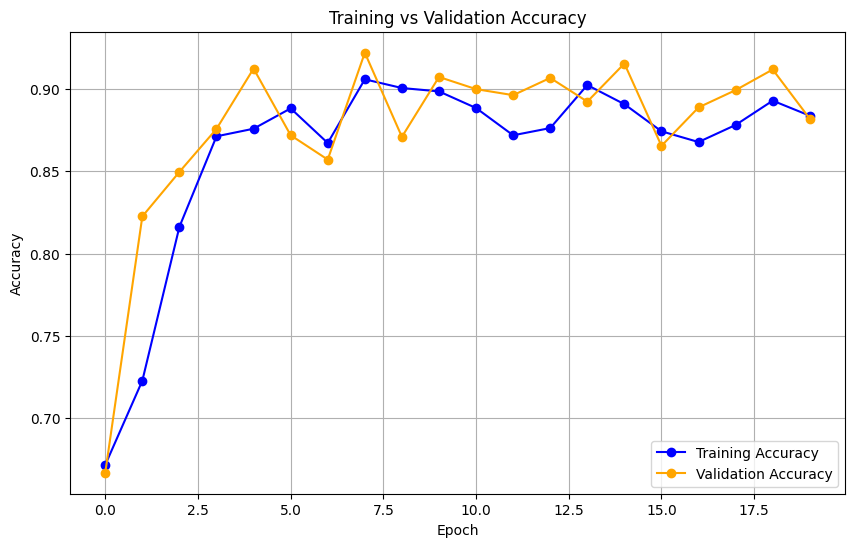

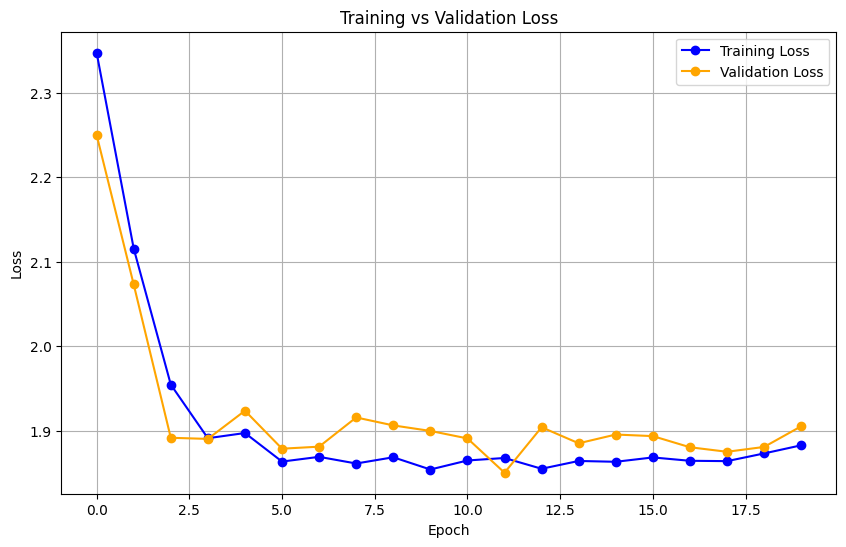

In [ ]:
import matplotlib.pyplot as plt

# Training vs Validation Accuracy Graph
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(valid_accuracies, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Training vs Validation Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(valid_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

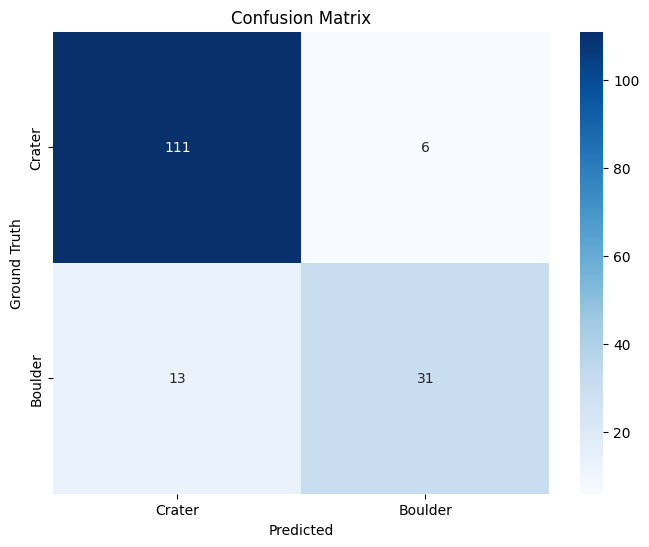

Confusion Matrix:
[[111   6]
 [ 13  31]]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure valid_preds_all and valid_labels_all are numpy arrays
valid_preds_all = np.array(valid_preds_all)
valid_labels_all = np.array(valid_labels_all)

# Compute confusion matrix
cm = confusion_matrix(valid_labels_all, valid_preds_all)

# Define class names (adjust if labels start at 1)
class_names = train_dataset.classes  # ['Crater', 'Boulder']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix as text (optional)
print("Confusion Matrix:")
print(cm)

Image 1 Ground Truth: 19 Craters, 3 Boulders
Image 1 Boulder Scores: [0.3201655  0.27997515 0.2666418  0.25517672 0.21957463 0.21253648
 0.21052743 0.20706248 0.1985166  0.19092983 0.19090112 0.18088281
 0.17783888 0.17382838 0.16771597 0.16690543 0.15189658 0.15129596
 0.15077968 0.14980665 0.14635164 0.14627148 0.14567131 0.14405082
 0.14292884 0.14200543 0.14178658 0.13672094 0.13535191 0.1336105
 0.1297999  0.12848721 0.12487194 0.12351176 0.12295067 0.12128749
 0.11794513 0.11537556 0.11489653 0.11209741 0.11050908 0.10960707
 0.10826033 0.10675166 0.10658289 0.10391345 0.10358915 0.10258719
 0.10192855 0.10174216 0.10152968 0.09883682 0.09800635 0.09763192
 0.09707221 0.09670262 0.09558529 0.09422531 0.09394623 0.09353874
 0.09292378 0.09256587 0.09050924 0.09032013 0.08707648 0.08702987
 0.08656727 0.08629625 0.08501781 0.08441618 0.08411308 0.08333364
 0.08322503 0.0829856  0.08212685 0.08195864 0.08098885 0.0809443
 0.07993933 0.07976044 0.07923713 0.07747369 0.07746226 0.0771

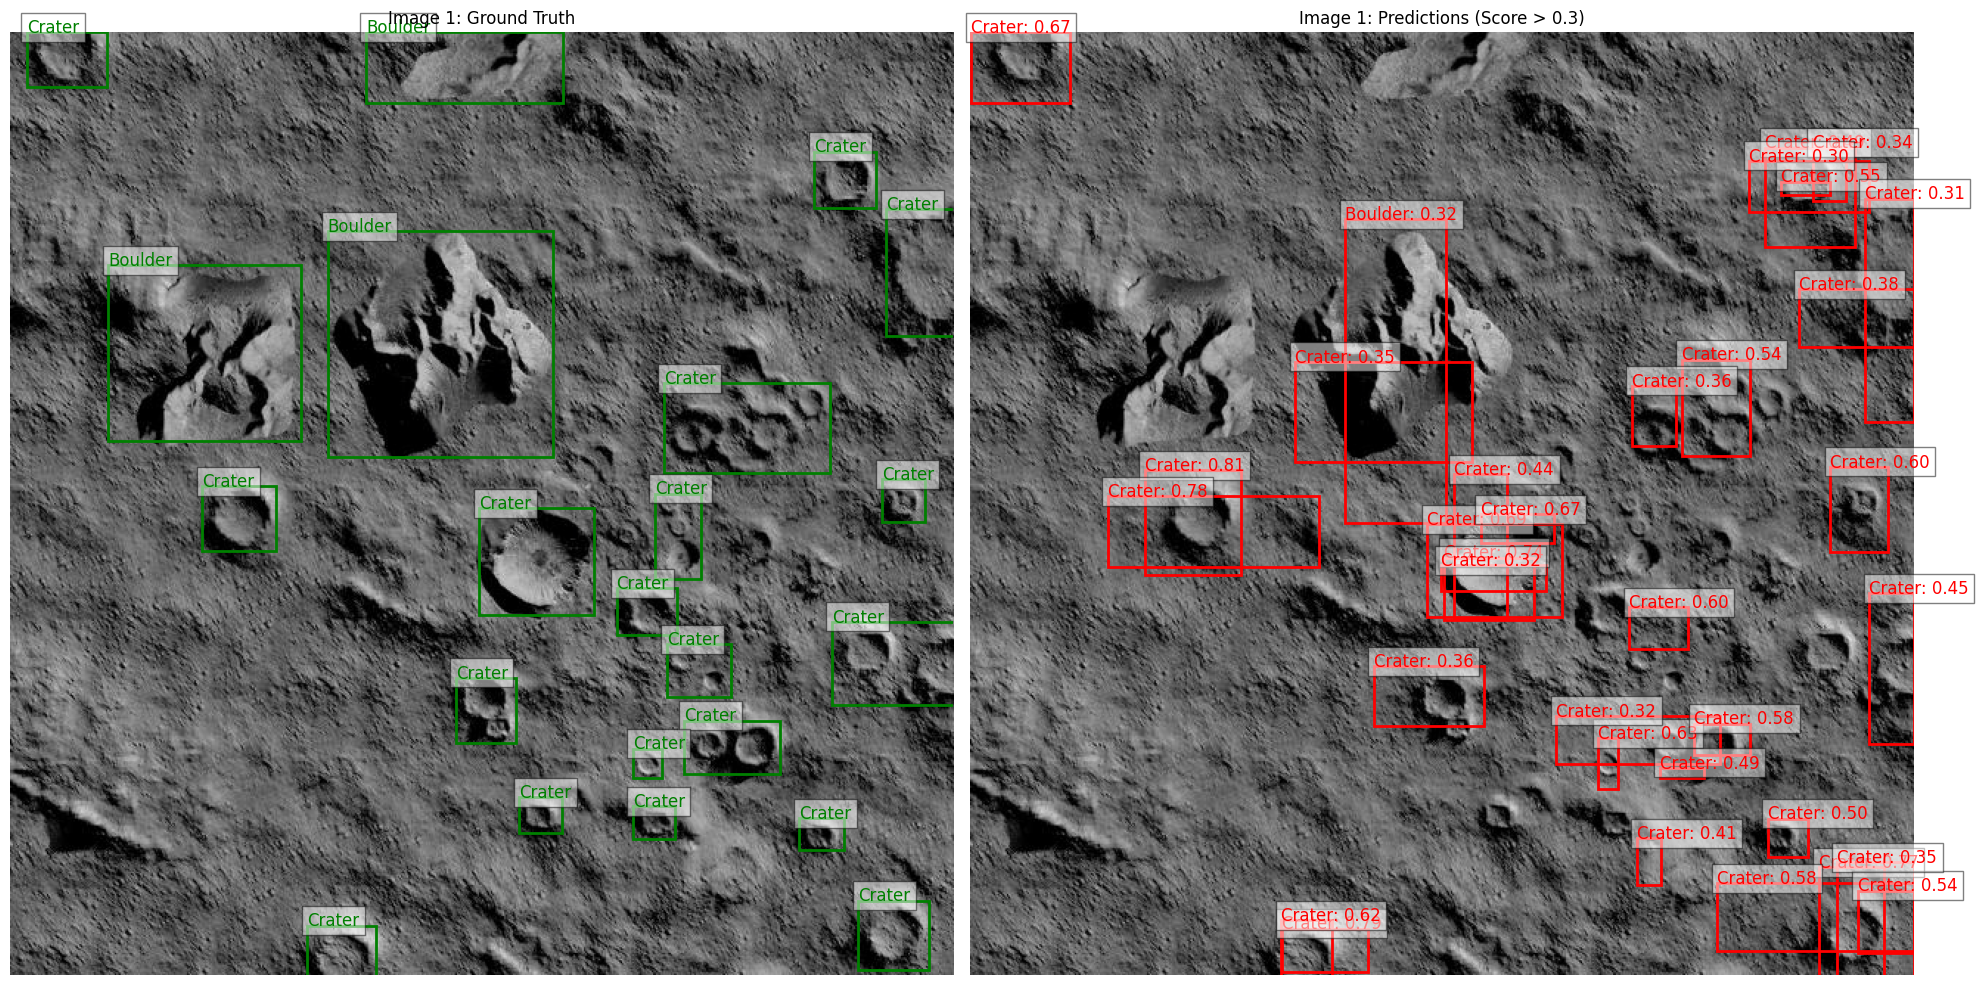

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_separate_predictions(images, preds, targets, class_names, num_images=2, score_threshold=0.3):
    model.eval()
    with torch.no_grad():
        for i in range(min(num_images, len(images))):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

            # Ground Truth Image
            ax1.imshow(img)
            gt_boxes = targets[i]['boxes'].cpu().numpy()
            gt_labels = targets[i]['labels'].cpu().numpy()
            for box, label in zip(gt_boxes, gt_labels):
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
                ax1.add_patch(rect)
                ax1.text(x1, y1, class_names[label - 1], color='g', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
            ax1.set_title(f"Image {i+1}: Ground Truth")
            ax1.axis('off')

            # Predicted Image
            ax2.imshow(img)
            pred_boxes = preds[i]['boxes'].cpu().numpy()
            pred_labels = preds[i]['labels'].cpu().numpy()  # Fixed: preds[i]
            pred_scores = preds[i]['scores'].cpu().numpy()  # Fixed: preds[i]
            for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                if score > score_threshold:
                    x1, y1, x2, y2 = box
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
                    ax2.add_patch(rect)
                    ax2.text(x1, y1, f"{class_names[label - 1]}: {score:.2f}", color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
            ax2.set_title(f"Image {i+1}: Predictions (Score > {score_threshold})")
            ax2.axis('off')

            plt.tight_layout()
            plt.show()

# Get a batch from validation loader
images, targets, _ = next(iter(valid_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model.eval()
with torch.no_grad():
    preds = model(images)

# Debug ground truth content
for i, target in enumerate(targets):
    gt_labels = target['labels'].cpu().numpy()
    boulder_count = sum(gt_labels == 2)
    crater_count = sum(gt_labels == 1)
    print(f"Image {i+1} Ground Truth: {crater_count} Craters, {boulder_count} Boulders")

# Debug prediction scores
for i, pred in enumerate(preds):
    pred_labels = pred['labels'].cpu().detach().numpy()
    pred_scores = pred['scores'].cpu().detach().numpy()
    boulder_indices = pred_labels == 2
    if boulder_indices.any():
        print(f"Image {i+1} Boulder Scores: {pred_scores[boulder_indices]}")
    else:
        print(f"Image {i+1}: No Boulder Predictions")

# Visualize with very low threshold
visualize_separate_predictions(images, preds, targets, train_dataset.classes, score_threshold=0.3)